# Polygon workaround

- **Idea**: Building a shape vector for each contour point

- **Construction step**:
    1. Pre-processing
        + Load image
        + Load the list of color

    2. Extracting contour
        + Extract contour based on DBz map
        + Reduce the number of vertices using *Douglas-Peucker* algorithm
    
    3. Building shape vector map
        + Build a shape vector for each vertex in the boundary

## I. Load data

In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
import cv2

from src.preprocessing import sorted_color, read_image
from src.identification import extract_contour_by_dbz, SimpleContourIdentifier
from src.utils.polar_description_vector import process_contours, polygons_to_contours, construct_shape_vector, ShapeVector

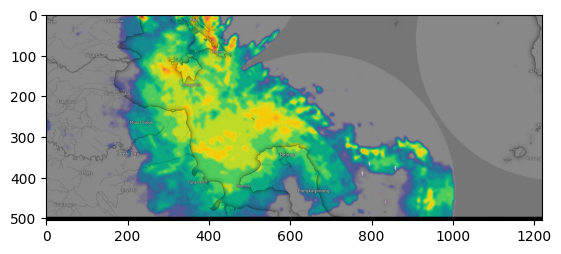

(505, 1220, 3)

In [2]:
img_path = 'data/images/malaysia_-1.464_106.013/20250105-212045.png'
src_img = read_image(img_path)

plt.imshow(src_img)
plt.show()
src_img.shape

## 2. Extract contours

In [ ]:
# from src.preprocessing import _preprocess, _convert_to_dbz, sorted_color

# THRESHOLD_AREA = 100

# def extract_contour_by_dbz(img: np.ndarray, threshold: int, threshold_area: int = THRESHOLD_AREA) -> np.ndarray:
#     """
#         Draw the DBZ contour for the image.

#         Args:
#             img: source image.
#             thresholds: dbz thresholds for drawing contours.
#             sorted_color: a list of tuples where each tuple includes:
#                 - a color represented as an RGB triplet (e.g., (R, G, B)).
#                 - a corresponding dBZ value, sorted in increasing order of dBZ.
        
#         Returns:
#             Tuple[np.ndarray,List[np.ndarray]]: A tuple containing:
#                 - contour_img (np.ndarray): A blank image with the extracted contours drawn.
#                 - contours (List[np.ndarray]): A list of detected contours, each represented as an array of points.
#                 - contour_colors (List(Tuple[int,int,int])): A list of color corresponding with each contours
#     """
#     img = _preprocess(img)
#     dbz_map = _convert_to_dbz(img, sorted_color).astype(np.uint8)

#     # Get the region
#     region = (dbz_map >= threshold).astype(np.uint8)

#     # Draw the contour
#     contours, _ = cv2.findContours(region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     contours = sorted([polygon for polygon in contours if cv2.contourArea(polygon) >= threshold_area], 
#                       key=lambda x: cv2.contourArea(x), reverse=True)

#     return contours

Number of polygons = 14


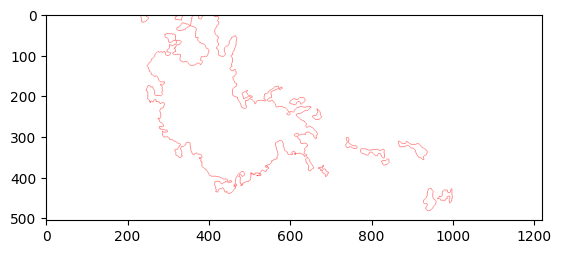

In [7]:
storm_identifier = SimpleContourIdentifier()
blank_img = np.ones_like(src_img) * 255
contours  = storm_identifier.identify_storm(src_img, threshold=30, filter_area=100)

for polygon in contours:
    cv2.drawContours(blank_img, [polygon], -1, (255,0,0))

print(f"Number of polygons = {len(contours)}")

plt.imshow(blank_img)
plt.show()

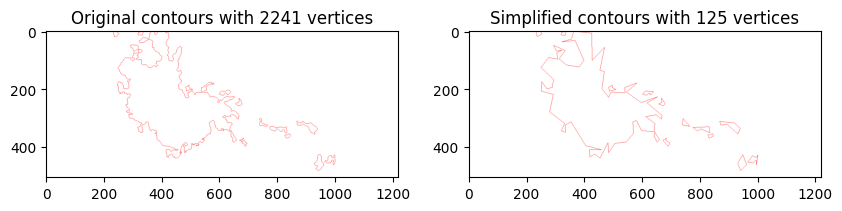

In [8]:
polygons = process_contours(contours)
simplified_contours = polygons_to_contours(polygons)

original_vertices = sum([contour.shape[0] for contour in contours])
simplified_vertices = sum([contour.shape[0] for contour in simplified_contours])

plt.figure(figsize=(10, 20))

plt.subplot(1, 2, 1)
# Left: simplified contour
blank_img = np.ones(shape=src_img.shape, dtype=np.uint8) * 255
cv2.drawContours(blank_img, contours, contourIdx=-1, color=(255, 0, 0), thickness=1)
plt.title(f"Original contours with {original_vertices} vertices")
plt.imshow(blank_img)

# Right: contour
plt.subplot(1, 2, 2)
blank_img = np.ones(shape=src_img.shape, dtype=np.uint8) * 255
cv2.drawContours(blank_img, simplified_contours  , contourIdx=-1, color=(255, 0, 0), thickness=1)
plt.title(f"Simplified contours with {simplified_vertices} vertices")
plt.imshow(blank_img)

plt.show()

## 3. Build vector map for each point in contours

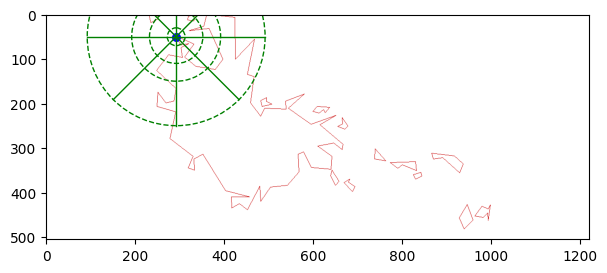

In [ ]:
def plot_shape_vector(contours, point_A, radii, num_sectors):
    plt.figure(figsize=(7, 7))
    fig = plt.gcf()
    ax = fig.gca()

    blank_img = np.ones_like(src_img, dtype=np.int16) * 255

    # Plot polygon (assuming you have a helper function plot_contour)
    cv2.drawContours(blank_img, contours, -1, color=(200,0,0), thickness=1)

    # Add circles
    for r in radii:
        circle = plt.Circle(point_A, radius=r, color='green', fill=False, linestyle="--")
        ax.add_patch(circle)

    # Add radial lines (sectors)
    longest_r = max(radii)
    for i in range(num_sectors):
        grad_angle = np.deg2rad(i * (360 / num_sectors))
        x_start, y_start = point_A
        x_end = x_start + np.cos(grad_angle) * longest_r
        y_end = y_start + np.sin(grad_angle) * longest_r
        plt.plot([x_start, x_end], [y_start, y_end], color="green", linewidth=1)

    # Mark the reference point
    plt.scatter([point_A[0]], [point_A[1]], marker='o', s=30, color="blue", label="Point A")

    plt.imshow(blank_img)
    plt.show()

radii = [20, 60, 100, 200]
num_sectors = 8

point = simplified_contours[0][9][0]
features_vector = construct_shape_vector(polygons, point, radii=radii, num_sectors=num_sectors)

plot_shape_vector(simplified_contours, point, radii, num_sectors)

## 3. Extract a global set of keypoints of weather image

In [10]:
points = [point for contour in simplified_contours for point in contour.squeeze(1)]

point_features = []

for point in points:
    try:
        point_features.append((
            ShapeVector(point, construct_shape_vector(polygons, point, radii=radii, num_sectors=num_sectors))
        ))
    except:
        pass

len(points), len(point_features)

(125, 125)

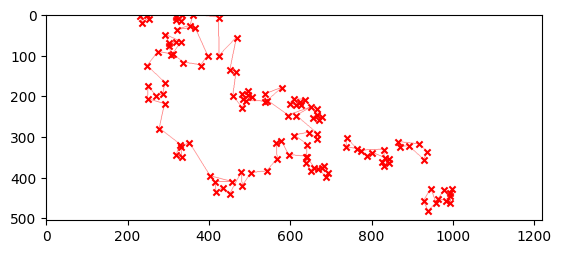

In [11]:
blank_img = np.ones_like(src_img, np.int16) * 255
cv2.drawContours(blank_img, simplified_contours, contourIdx=-1, color=(255, 0, 0), thickness=1)
plt.imshow(blank_img)

for point in points:
    plt.scatter(point[0], point[1], s=20, c='red', marker='x')

plt.show()

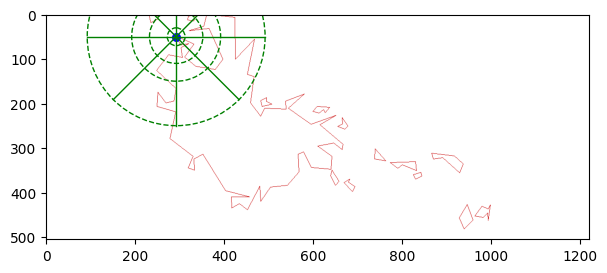

In [12]:
plot_shape_vector(simplified_contours, points[9], radii=radii, num_sectors=num_sectors)
plt.show()